# Advanced Simulation of an FMU
Tutorial by Johannes Stoljar, Tobias Thummerer

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons, Josef Kircher, Johannes Stoljar
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

## Motivation
This Julia Package *FMI.jl* is motivated by the use of simulation models in Julia. Here the FMI specification is implemented. FMI (*Functional Mock-up Interface*) is a free standard ([fmi-standard.org](http://fmi-standard.org/)) that defines a container and an interface to exchange dynamic models using a combination of XML files, binaries and C code zipped into a single file. The user can thus use simulation models in the form of an FMU (*Functional Mock-up Units*). Besides loading the FMU, the user can also set values for parameters and states and simulate the FMU both as co-simulation and model exchange simulation.

## Introduction to the example
In this example we would like to show that besides the simple simulation of an FMU there is also a more advanced version of the simulation. The advantage of the more advanced variant is that there are more possibilities to intervene in the simulation to make changes. After the FMU has been simulated, the simulation results are displayed in a graph. The used model is a one-dimensional spring pendulum with friction. The object-orientated structure of the *SpringFrictionPendulum1D* can be seen in the following graphic.

![svg](https://github.com/thummeto/FMI.jl/blob/main/docs/src/examples/pics/SpringFrictionPendulum1D.svg?raw=true)  


## Target group
The example is primarily intended for users who work in the field of simulations. The example wants to show how simple it is to use FMUs in Julia.


## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/modelica_conference_2021.ipynb) there is also a [Julia file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/modelica_conference_2021.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/modelica_conference_2021.md) corresponding to the notebook.  


## Getting started

### Installation prerequisites

|     | Description                       | Command                   | Alternative                                    |   
|:----|:----------------------------------|:--------------------------|:-----------------------------------------------|
| 1.  | Enter Package Manager via         | ]                         |                                                |
| 2.  | Install FMI via                   | add FMI                   | add " https://github.com/ThummeTo/FMI.jl "     |
| 3.  | Install FMIZoo via                | add FMIZoo                | add " https://github.com/ThummeTo/FMIZoo.jl "  |
| 4.  | Install Plots via                 | add Plots                 |                                                |

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMIZoo
using Plots

### Simulation setup

Next, the start time and end time of the simulation are set. Finally, a step size is specified to store the results of the simulation at these time steps.

In [3]:
tStart = 0.0
tStep = 0.1
tStop = 8.0
tSave = tStart:tStep:tStop

0.0:0.1:8.0

### Simple FMU Simulation

In the next lines of code the FMU model from *FMIZoo.jl* is loaded and the information about the FMU is shown.

In [4]:
# we use an FMU from the FMIZoo.jl
pathToFMU = get_model_filename("SpringFrictionPendulum1D", "Dymola", "2022x")

myFMU = fmiLoad(pathToFMU)
fmiInfo(myFMU)

#################### Begin information for FMU ####################
	Model name:			SpringFrictionPendulum1D
	FMI-Version:			2.0
	GUID:				{2e178ad3-5e9b-48ec-a7b2-baa5669efc0c}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:12Z
	Var. naming conv.:		structured
	Event indicators:		24
	Inputs:				0
	Outputs:			0
	States:				2
		33554432 ["mass.s"]
		33554433 ["mass.v", "mass.v_relfric"]
	Supports Co-Simulation:		true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringFrictionPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


In the next commands the FMU is simulated, for which the start and end time and recorded variables are declared. Afterwards the simulation result is shown in a graph. In the plot for the FMU, it can be seen that the oscillation keeps decreasing due to the effect of friction. If one simulates long enough, the oscillation comes to a standstill after a certain time.

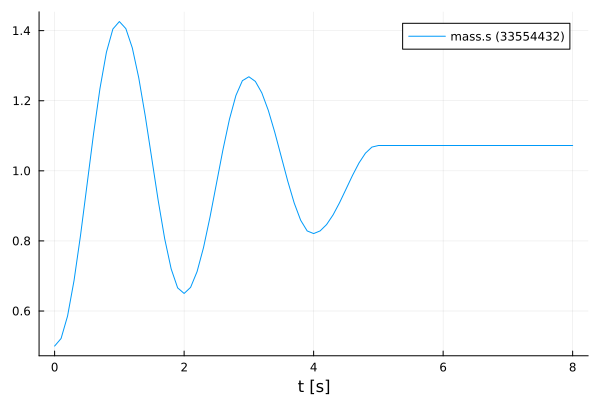

In [5]:
simData = fmiSimulate(myFMU, (tStart, tStop); recordValues=["mass.s"], saveat=tSave)
fmiPlot(simData)

After plotting the data, the FMU is unloaded and all unpacked data on disc is removed.

In [6]:
fmiUnload(myFMU)

### Advanced FMU Simulation

In the following type of simulation a more advanced variant is presented, which allows intervening more in the simulation process. Analogous to the simple variant, an FMU model must be loaded.

In [7]:
myFMU = fmiLoad(pathToFMU);

Next, it is necessary to create an instance of the FMU, this is achieved by the command `fmiInstantiate!()`.  

In [8]:
instanceFMU = fmiInstantiate!(myFMU)

FMU:            SpringFrictionPendulum1D
InstanceName:   SpringFrictionPendulum1D
Address:        Ptr{Nothing} @0x000000000804df90
State:          0
Logging:        false
FMU time:       -Inf
FMU states:     nothing

In the following code block, start and end time for the simulation is set by the `fmiSetupExperiment()` command. Next, the FMU is initialized by the calls of `fmiEnterInitializationMode()` and `fmiExitInitializationMode()`. It would also be possible to set initial states for the FMU before these two commands. 

In [9]:
fmiSetupExperiment(instanceFMU, tStart, tStop)
# set initial model states
fmiEnterInitializationMode(instanceFMU)
# get initial model states
fmiExitInitializationMode(instanceFMU)

0x00000000

The actual simulation loop is shown in the following block. Here a simulation step `fmiDoStep()` with the fixed step size `tStep` is executed. As indicated in the code by the comments, the input values and output values of the FMU could be changed in the simulation loop as desired, whereby the higher possibility of adjustments arises.

In [10]:
for t in tSave
    # set model inputs 
    # ...
    fmiDoStep(instanceFMU, tStep)
    # get model outputs
    # ...
end

[Warning][][SpringFrictionPendulum1D]: : trying to compute past tStop = 8.000000, to 8.0999999999999872,  at t = 8.000000


The instantiated FMU must be terminated and then the memory area for the instance can also be deallocated. The last step is to unload the FMU to remove all unpacked data on disc. 

In [11]:
fmiTerminate(instanceFMU)
fmiFreeInstance!(instanceFMU)
fmiUnload(myFMU)

[OK][CvodeStatistics][SpringFrictionPendulum1D]: Sundials CVode Statistics
    Stop time                                : 8.00 s
    Simulation time                          : 0.40 s
    Number of external steps                 : 80
    Number of internal steps                 : 191
    Number of non-linear iterations          : 263
    Number of non-linear convergence failures: 0
    Number of f function evaluations         : 291
    Number of g function evaluations         : 339
    Number of Jacobian-evaluations (direct)  : 7
    Maximum integration order                : 5
    Suggested tolerance scale factor         : 1.0
    Grouping used                            : no



### Summary

The tutorial has shown that besides the usual simple variant of simulating an FMU, there is another way to make more adjustments.